<a href="https://colab.research.google.com/github/tavarel/FerramentasAnalisesFinanceiras/blob/main/MC%26HRP_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.0 MB/s eta 0:00:00


In [14]:

# Importando bibliotecas
from cProfile import label
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
from pandas_datareader import data as wb
from datetime import datetime
from scipy.optimize import minimize
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns



In [15]:
# Programa essencialmente está "Chutando a melhor alocação"
acoes = ['KO', 'AAPL', 'META', 'TOTS3.SA', 'ITUB4.SA', 'BBDC4.SA']

acoes_df = pd.DataFrame()
for acao in acoes:
    acoes_df[acao] = yf.download(acao, start='2017-01-01')['Adj Close']
acoes_df.dropna(inplace=True)
acoes_df2 = acoes_df.copy()


def alocacao_ativos(dataset, dinheiro_total, seed=0, melhores_pesos=[]):
    dataset = dataset.copy()

    if seed != 0:
        np.random.seed(seed)

    colunas = dataset.columns
    n_colunas = len(colunas)

    if len(melhores_pesos) > 0:
        pesos = melhores_pesos[:n_colunas]
    else:
        pesos = np.random.random(n_colunas)
        pesos /= np.sum(pesos)

    for i in colunas:
        dataset[i] = (dataset[i] / dataset[i].iloc[0])

    for i, acao in enumerate(colunas):
        dataset[acao] *= pesos[i] * dinheiro_total

    dataset['soma valor'] = dataset.sum(axis=1)
    dataset['taxa retorno'] = dataset['soma valor'].pct_change() * 100

    acoes_pesos = pd.DataFrame(data={'Acoes': colunas, 'Pesos': pesos * 100})

    return dataset, acoes_pesos, dataset['soma valor'].iloc[-1]


#dataset, acoes_pesos, soma_valor = alocacao_ativos(acoes_df2, 10000)

#print(dataset.tail())
#print(acoes_pesos)
#print(soma_valor)


# Otimização de portifólio atráves de alocação de ativos utilizando a teoria de Markowitz com Machine learning

dinheiro_total = 1000

taxa_selic_2015 = 12.75
taxa_selic_2016 = 14.25
taxa_selic_2017 = 13.25
taxa_selic_2018 = 6.50
taxa_selic_2019 = 5.0
taxa_selic_2020 = 2.0
taxa_selic_2021 = 6.25
taxa_selic_2022 = 13.75
taxa_selic_2023 = 11.75


valor_2017 = dinheiro_total + (dinheiro_total * taxa_selic_2017/100)
valor_2017
valor_2018 = valor_2017 + (dinheiro_total * taxa_selic_2018/100)
valor_2018
valor_2019 = valor_2018 +(valor_2018 * taxa_selic_2019 / 100)
valor_2019
valor_2020 = valor_2019 +(valor_2019 * taxa_selic_2020 / 100)
valor_2020
valor_2021 = valor_2020 +(valor_2020 * taxa_selic_2021 / 100)
valor_2021
valor_2022 = valor_2021 +(valor_2021 * taxa_selic_2022 / 100)
valor_2022
valor_2023 = valor_2022 +(valor_2022 * taxa_selic_2023 / 100)
valor_2023

taxa_selic_historico = np.array([13.25, 6.5, 5.0, 2.0, 6.25, 13.75, 11.75])
sem_risco = taxa_selic_historico.mean() / 100

acoes_df2.reset_index(inplace=True)

def fitness_function(solucao):
    dinheiro_total = 1000
    dataset = acoes_df2.copy()
    solucao = solucao + 1e-5  # Adiciona uma pequena constante aos pesos
    solucao = solucao / np.sum(solucao)  # Normaliza os pesos novamente

    # Excluindo a coluna 'Date' do cálculo
    colunas = dataset.columns[1:]  # Ignora a coluna 'Date'

    for i, acao in enumerate(colunas):
        dataset[acao] *= solucao[i] * dinheiro_total

    dataset.drop(labels=['Date'], axis=1, inplace=True)
    dataset['soma valor'] = dataset.sum(axis=1)
    retorno = dataset.pct_change()
    retorno.dropna(inplace=True)

    sharpe_ratio = retorno['soma valor'].mean() / retorno['soma valor'].std()
    return sharpe_ratio

print(acoes_df2)

np.random.seed(0)
pesos = np.random.random(len(acoes_df2.columns) -1 )
pesos = pesos / pesos.sum()

fitness_function(pesos)

def visualiza_alococao(solucao):
    colunas = acoes_df2.columns[1:]
    for i in range(min(len(solucao), len(colunas))):
        print(f'{colunas[i]}: {solucao[i] * 100:.2f}%')

visualiza_alococao(pesos)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
           Date         KO        AAPL        META   TOTS3.SA   ITUB4.SA  \
0    2017-01-03  33.438908   27.023705  116.860001   7.671146  17.357222   
1    2017-01-04  33.318916   26.993462  118.690002   7.624749  17.431709   
2    2017-01-05  33.398911   27.130726  120.669998   7.664959  17.670086   
3    2017-01-06  33.390903   27.433189  123.410004   7.426783  17.729692   
4    2017-01-09  33.054913   27.684464  124.900002   7.457715  17.814116   
...         ...        ...         ...         ...        ...        ...   
1699 2024-01-08  60.110001  185.559998  358.660004  32

In [22]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import risk_models, expected_returns, plotting
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.black_litterman import market_implied_prior_returns
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [31]:
# Cálculo de retornos esperados e matriz de covariância
media_retorno_anual = expected_returns.mean_historical_return(acoes_df)
matriz_covariancia_anual = risk_models.sample_cov(acoes_df)


Ações : ['KO', 'AAPL', 'META', 'TOTS3.SA', 'ITUB4.SA', 'BBDC4.SA'] 
Melhores Pesos da Simulação Monte Carlo: [0.11452533 0.65161977 0.03429119 0.10561646 0.08309273 0.01085452]


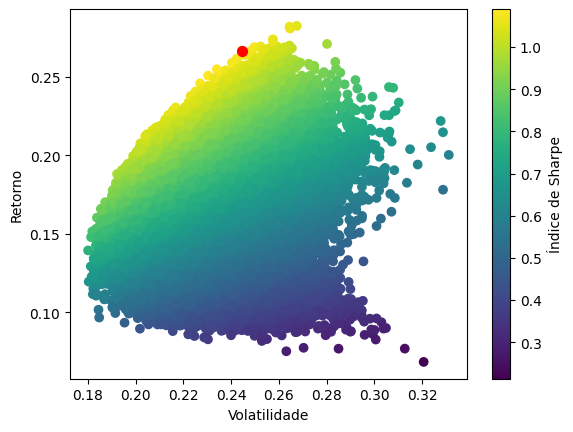

In [37]:
# Otimização com Simulação Monte Carlo
n_portfolios = 200000
all_weights = np.zeros((n_portfolios, len(acoes_df.columns)))
ret_arr = np.zeros(n_portfolios)
vol_arr = np.zeros(n_portfolios)
sharpe_arr = np.zeros(n_portfolios)

for ind in range(n_portfolios):
    # Criar pesos aleatórios
    pesos = np.array(np.random.random(len(acoes_df.columns)))
    pesos = pesos / np.sum(pesos)

    # Salvar pesos
    all_weights[ind, :] = pesos

    # Retorno esperado
    ret_arr[ind] = np.sum((media_retorno_anual.values * pesos))

    # Volatilidade esperada
    vol_arr[ind] = np.sqrt(np.dot(pesos.T, np.dot(matriz_covariancia_anual, pesos)))

    # Índice de Sharpe
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]

# Resultados da Simulação Monte Carlo
max_sharpe_ratio = sharpe_arr.max()
max_sharpe_ratio_loc = sharpe_arr.argmax()
optimal_mc_weights = all_weights[max_sharpe_ratio_loc, :]

print(f'Ações : {acoes} ' )
print("Melhores Pesos da Simulação Monte Carlo:", optimal_mc_weights)

# Visualização da Fronteira Eficiente
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Índice de Sharpe')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(vol_arr[max_sharpe_ratio_loc], ret_arr[max_sharpe_ratio_loc], c='red', s=50) # ponto vermelho
plt.show()

In [35]:

#Hierarchical Risk Parity Test


import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import HRPOpt

# Definindo a lista de ativos (tickers) para o portfólio
tickers = ['KO', 'AAPL', 'META', 'TOTS3.SA', 'ITUB4.SA', 'BBDC4.SA']

# Baixando os dados de preço dos ativos
prices = yf.download(tickers, start='2017-01-01', end='2022-12-31')['Adj Close']

# Calculando os retornos logarítmicos dos ativos
log_returns = np.log(prices / prices.shift(1)).dropna()

# Criando uma instância do modelo HRP
hrp = HRPOpt(log_returns)

# Otimizando o portfólio para obter os pesos dos ativos
hrp_weights = hrp.optimize()

# Calculando o desempenho do portfólio
hrp_performance = hrp.portfolio_performance(verbose=True)

# Extraindo os pesos otimizados para cada ativo
weights_df = pd.DataFrame(list(hrp_weights.items()), columns=['ticker', 'weight']).set_index('ticker')

# Visualizando a árvore de clusterização
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

# Resultados de otimização do HRP
print("Pesos Otimizados pelo HRP:")
print(weights_df)

# Performance do portfólio HRP
print("Performance do Portfólio HRP:")
print(f"Retorno Esperado Anualizado: {hrp_performance[0]:.2f}%")
print(f"Volatilidade Anualizada: {hrp_performance[1]:.2f}%")
print(f"Índice de Sharpe: {hrp_performance[2]:.2f}")

[*********************100%%**********************]  6 of 6 completed
Expected annual return: 13.5%
Annual volatility: 19.6%
Sharpe Ratio: 0.59
Pesos Otimizados pelo HRP:
            weight
ticker            
AAPL      0.129987
BBDC4.SA  0.085505
ITUB4.SA  0.105337
KO        0.476514
META      0.072453
TOTS3.SA  0.130203
Performance do Portfólio HRP:
Retorno Esperado Anualizado: 0.14%
Volatilidade Anualizada: 0.20%
Índice de Sharpe: 0.59
